In [1]:
#import tkinter as tk
import pandas as pd
import math
import pandas as pd
import numpy as np
import cv2
import random

#import pygetwindow as gw
#import pyautogui
import threading
import time

from PIL import Image, ImageStat
from matplotlib import pyplot as plt
from os.path import exists

# for inventory item detection

In [2]:
def edge_detection(img_np):
    img = img_np.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.Canny(img, threshold1=50, threshold2=200, apertureSize=5)
    img = cv2.blur(img, (3,3))
    return img

def inventory_line_detection(img):
    global window_scale_factor
    img_inventory_edge = edge_detection(img)
    
    # horizontal and vertical line detection
    line_length = (int) (40 * window_scale_factor)
    img_horizontal = img_inventory_edge.copy()
    img_vertical = img_inventory_edge.copy()

    horizontal_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (line_length,1))
    vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,line_length))
    cv2.erode(img_horizontal, horizontal_struct, img_horizontal)
    cv2.erode(img_vertical, vertical_struct, img_vertical)
    cv2.dilate(img_horizontal, horizontal_struct, img_horizontal)
    cv2.dilate(img_vertical, vertical_struct, img_vertical)

    result = cv2.add(img_horizontal, img_vertical)
    return result

def find_slot_locations(inventory_filtered, slot_gray, min_x = 1000):
    slot_x_offset = min_x
    slot_y_offset = 100
    slot_x_max = 2900
    slot_y_max = 1300
    inv = inventory_filtered[slot_y_offset:slot_y_max, slot_x_offset:slot_x_max].copy()
    slot = slot_gray.copy()
    
    matched_slots = cv2.matchTemplate(inv, slot, cv2.TM_CCORR_NORMED)
    
    threshold = 0.6
    min_distance = 60

    slot_locations = []
    slot_locations_filtered = []
    for y in range(matched_slots.shape[0]):
        for x in range(matched_slots.shape[1]):
            if matched_slots[y][x] > threshold:
                slot_locations.append((x,y))
    
    # filter number of locations
    for x,y in slot_locations:
        add_slot = True
        for s in slot_locations_filtered:
            if abs(s[0]-x) < min_distance and abs(s[1]-y) < min_distance:
                add_slot = False
                break
        if add_slot == True:
            slot_locations_filtered.append((x,y))
    
    # add offset to slot locations
    for i in range(len(slot_locations_filtered)):
        x,y = slot_locations_filtered[i]
        slot_locations_filtered[i] = (x+slot_x_offset, y+slot_y_offset)
            
    return slot_locations_filtered,matched_slots

def draw_slots_on_image(img, slots, color=(255,0,0)):
    img_with_slots = img.copy()
    for x,y in slots:
        img_with_slots = cv2.circle(img_with_slots, (x, y), radius=5, color=color, thickness=-1)
    return img_with_slots

def get_items_from_inventory(inventory, slots):
    global slot_size
    
    items = []
    for s in slots:
        items.append(inventory[s[1]:s[1]+slot_size, s[0]:s[0]+slot_size])
        
    return items

# to predict the item image

In [3]:
def scale_image(image, scale_factor=2, width=-1, height=-1):
    if width == -1 or height == -1:
        width = (int) (image.shape[1]*scale_factor)
        height = (int) (image.shape[0]*scale_factor)
    resized = cv2.resize(image, (width,height))
    return resized

In [4]:
def load_icons_from_disk(verbose=False):
    global all_items_df
    global path_grid_icons,filename_ending_grid_icon,window_scale_factor
    
    icons = []
    for index,item in all_items_df.iterrows():
        filename = path_grid_icons + item['id'] + filename_ending_grid_icon
        if not exists(filename):
            icons.append([])
            if verbose:
                print(f"File {filename} does not exist.")
                continue
        else:
            width_in_slots = item.loc['width']
            height_in_slots = item.loc['height']
            icon = np.asarray(Image.open(filename))
            icon = scale_image(icon, width=(int) (width_in_slots*slot_size*window_scale_factor)
                    , height=(int) (height_in_slots*slot_size*window_scale_factor))
            icons.append(icon)
        
    return icons

def run_sift(img, nr_corners=80, nr_selected_corners=999999, auto_threshold=True, verbose=False):
    global sift
    nr_selected_corners = min(nr_selected_corners, nr_corners)
    threshold_step = 2
    threshold = -threshold_step
    
    # adjust threshold to get consistent number of corners
    kp = []
    while len(kp) > nr_corners or len(kp) == 0:
        threshold += 2
        fast = cv2.FastFeatureDetector_create(threshold=threshold)
        kp = fast.detect(img, None)
        
        if len(kp) == 0:
            return [],None
        if not auto_threshold:
            break

    # histogram for empty slot detection
    hist_x = [0] * (img.shape[1])
    hist_y = [0] * (img.shape[0])
    empty_slot_threshold = 0.2*len(kp)
    for k in kp:
        hist_x[(int) (k.pt[0])] += 1
        hist_y[(int) (k.pt[1])] += 1
    if max(hist_x) > empty_slot_threshold or max(hist_y) > empty_slot_threshold:
        if verbose:
            print("I think this is an empty slot...")
        return [],None
    
    # randomly select kps to get them uniformly distributed
    kp_selected = kp
    if nr_selected_corners < nr_corners:
        kp_selected = []      
        for i in range(nr_selected_corners):
            rand_kp = kp[random.randint(0,len(kp)-1)]

            # filter kp from fir symbol
            # TODO: dynamic fir symbol size
            if rand_kp.pt[0] > 50 and rand_kp.pt[1] > 50:
                continue
            kp_selected.append(rand_kp)
    
    # compute descriptors
    kp,des = sift.compute(img, kp_selected)
    return kp,des

def create_all_descriptors():
    global icons,all_items_df

    descriptors = []
    descriptors_values = []
    descriptors_values_length = 0
    for i,icon in enumerate(icons):
        # no item icon
        if len(icon) == 0:
            descriptors.append(None)
            continue
        descriptors.append([])

        # descriptors for each item slot
        w = all_items_df.loc[i,'width']
        h = all_items_df.loc[i,'height']
        for x in range(w):
            for y in range(h):
                icon_slot = icon[y*slot_size:(y+1)*slot_size, x*slot_size:(x+1)*slot_size].copy()
                kp,des = run_sift(icon_slot, nr_corners=50)

                descriptors[i].append(descriptors_values_length)
                descriptors_values.append(des)
                descriptors_values_length += 1

    return descriptors, descriptors_values

def predict_icon(img, verbose=False):
    global icons, bf, descriptors, descriptors_values

    distances = []
    distances_local = []
    kp,des = run_sift(img, nr_corners=50, nr_selected_corners=10)

    if verbose:
        print(f"nr kp: {len(kp)}")

    for i in range(len(icons)):
        # no kp / des found
        if descriptors[i] is None:
            distances.append(999999)
            continue

        distances_local = []
        max_slots = min(6, len(descriptors[i])) # max slot size of considered items
        for j in range(max_slots):
            # no kp / des found for specific slot
            if descriptors_values[descriptors[i][j]] is None:
                distances_local.append(999999)
                continue

            matches = bf.match(des,descriptors_values[descriptors[i][j]])
            matches = sorted(matches, key = lambda x:x.distance)
            
            # if too few features, abort
            if len(matches) < 5:
                distances_local.append(999999)
                continue

            # sum up match distances
            distance = 0.0
            for match in matches:
                distance += match.distance
            distance = distance/len(matches)
            
            distances_local.append(distance)

        # return distance of best matching slot
        min_distance = min(distances_local)
        distances.append(min_distance)

    # item with lowest distance is prediction
    prediction = np.argmin(distances)
    min_distance = min(distances)
    
    if verbose:
        print(f"distance of prediction item: {min_distance}")
    
    return prediction,min_distance

def predict_all_icons(images, verbose=False):
    predictions = []
    distances = []
    for i,item in enumerate(images):
        if verbose and i%10 == 0:
            print(f"predicting item nr {i}")
        p,d = predict_icon(item)
        predictions.append(p)
        distances.append(d)
    return predictions,distances

In [5]:
def draw_keypoints(image, kp=None):
    img = image.copy()
    if kp is None:
        kp,des = run_sift(img)
    img = cv2.drawKeypoints(img,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

# find items in inventory

In [6]:
# paths
path_icons = '../../icons/'
path_images = '../../images/'
path_grid_icons = '../../grid_icons/'
path_data = '../../data/'

filename_ending_grid_icon = '-grid-image.jpg'

matched_slots = []

windows = False

In [7]:
window_scale_factor = 1.0
slot_size = 64

# get tarkov window
if windows:
    window_title_tarkov = 'EscapeFromTarkov'
    window_tarkov = gw.getWindowsWithTitle(window_title_tarkov)[0]
    window_tarkov_position = window_tarkov.topleft
    window_tarkov_size = window_tarkov.size

    window_scale_factor = window_tarkov_size[1] / 1080.0
    slot_size = (int) (64*window_scale_factor) # in pixels, for FHD resolution
    
else:
    window_scale_factor = 1080 / 1080.0
    slot_size = (int) (64*window_scale_factor) 

In [8]:
use_image = True or not windows

# load inventory image
img_inventory = None
if use_image:
    img_inventory = Image.open(path_images + 'inventar4.png')
    img_inventory = np.asarray(img_inventory)

else:
    screenshot = pyautogui.screenshot(region=(window_tarkov_position[0],window_tarkov_position[1]
                                              , window_tarkov_size[0], window_tarkov_size[1]))
    img_inventory = np.array(screenshot)

# filter inventory image
t0 = time.time()
inventory_filtered = inventory_line_detection(img_inventory)
print(f'filtering the inventory took {time.time()-t0} s')

filtering the inventory took 0.09098434448242188 s


In [9]:
# load and filter slot reference image
img_slot = Image.open(path_images + 'slot_empty.png')
img_slot = np.asarray(img_slot)
img_slot = scale_image(img_slot, scale_factor=window_scale_factor)
img_slot_gray = cv2.cvtColor(img_slot, cv2.COLOR_BGR2GRAY)

In [10]:
# find slots in inventory
t0 = time.time()
slot_locations, matched_slots = find_slot_locations(inventory_filtered, img_slot_gray, min_x=1000)
print(f'finding slots took {time.time()-t0} s')

finding slots took 3.4124655723571777 s


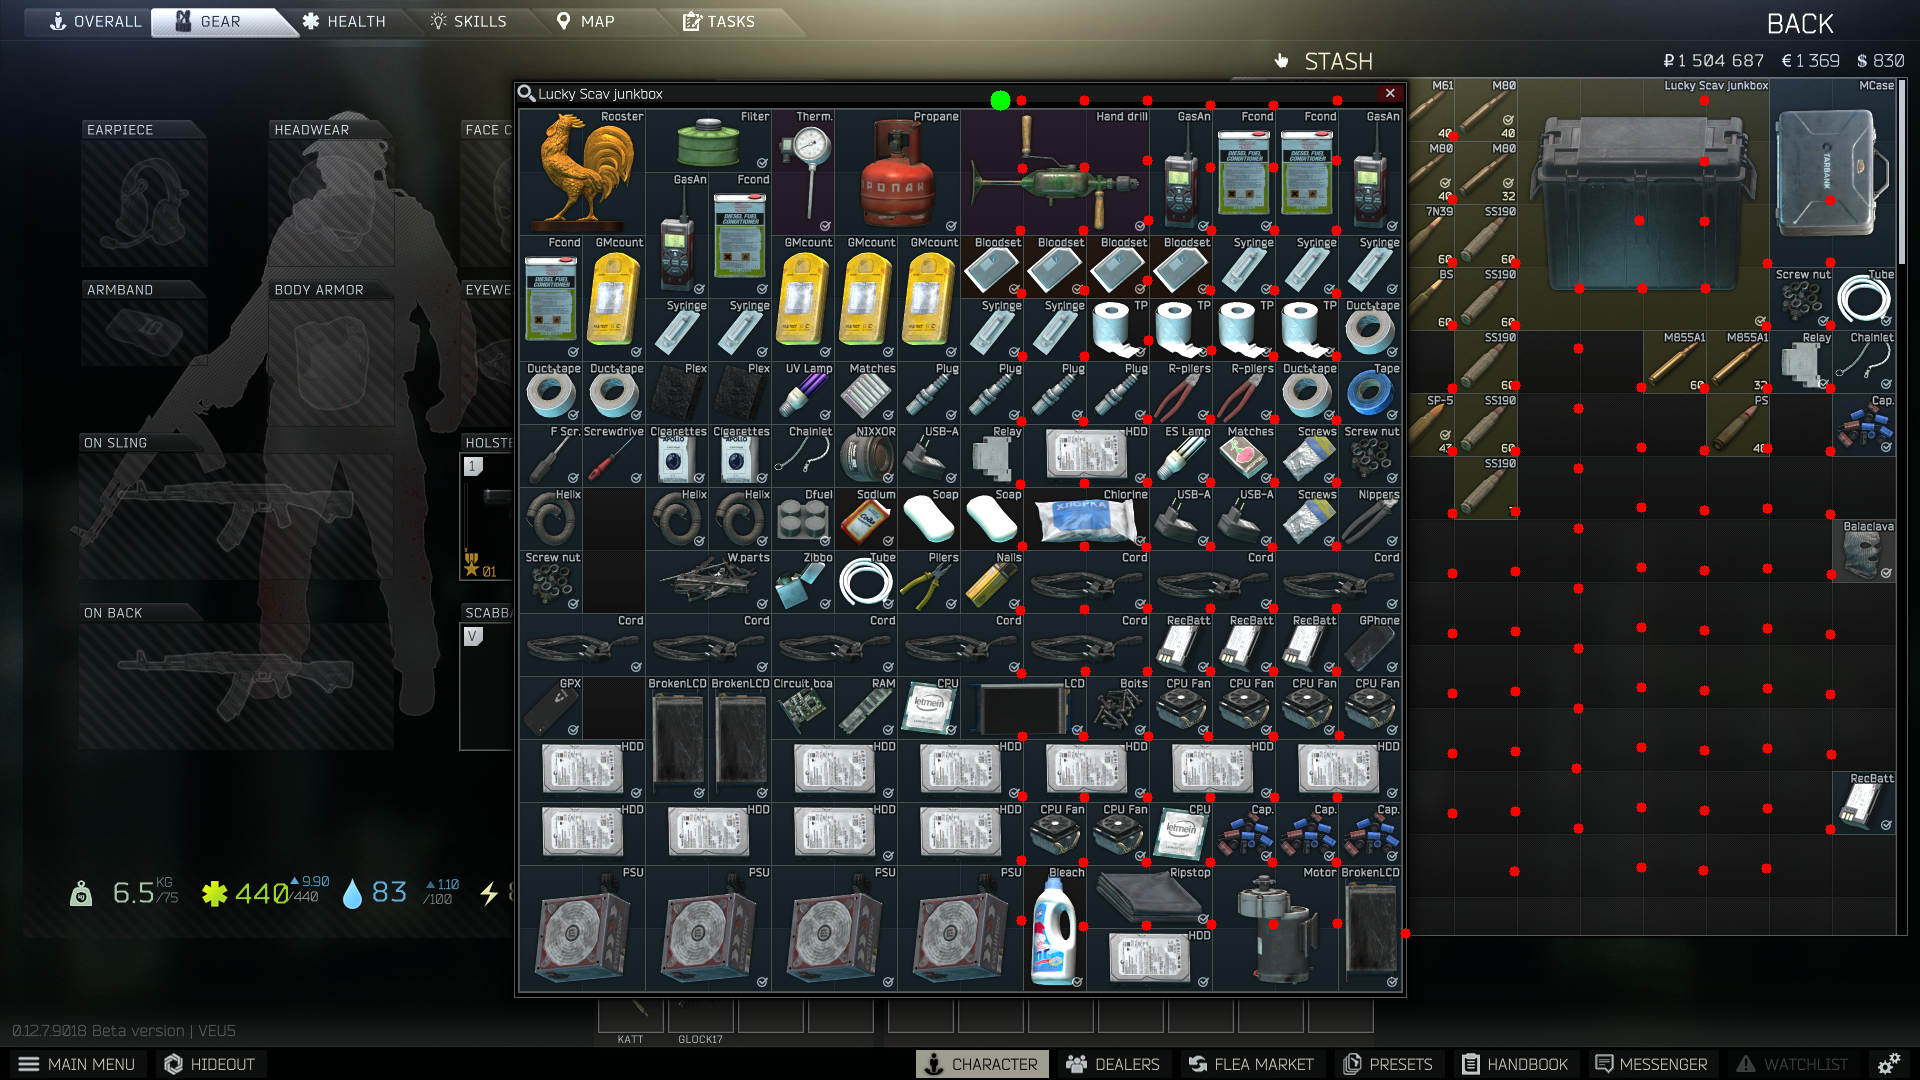

In [11]:
# draw slots on image
img_inventory = draw_slots_on_image(img_inventory, slot_locations)

img_inventory = cv2.circle(img_inventory, (1000, 100), radius=10, color=(0,255,0), thickness=-1)
img_inventory = cv2.circle(img_inventory, (2900, 1300), radius=10, color=(0,255,0), thickness=-1)

Image.fromarray(img_inventory)

In [12]:
# get item images from inventory
item_images = get_items_from_inventory(img_inventory, slot_locations)
print(f"there are {len(item_images)} item slots in the inventory")

there are 164 item slots in the inventory


# predict items

In [13]:
icons = []
descriptors = []
descriptors_values = []
all_items_df = None
predictions = []
distances = []

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

In [14]:
# get descriptors of all items
print("loading item data from disk")
all_items_df = pd.read_csv(path_data + 'all_items.csv')
print("loading item icons from disk")
icons = load_icons_from_disk()
print("creating descriptors for item icons")
descriptors, descriptors_values = create_all_descriptors()

loading item data from disk
loading item icons from disk
creating descriptors for item icons


In [24]:
# predict each item from inventory
predictions,distances = predict_all_icons(item_images)
predictions_df = pd.DataFrame({'slot_x': 0, 'slot_y': 0, 'predicted_item': predictions, 'distance': distances})

# put slot locations in prediction dataframe
for i in range(len(predictions_df)):
    predictions_df.loc[i,'slot_x'] = slot_locations[i][0]
    predictions_df.loc[i,'slot_y'] = slot_locations[i][1]

In [121]:
# save predictions to file
# predictions_df.to_csv(path_data + 'predictions_inventar4.csv', index=False)

# debugging stuff

In [122]:
# item_images

In [123]:
# threshold = 200000
# predictions_filtered = []
# for prediction in predictions:
#     if prediction[1] > threshold:
#         predictions_filtered.append((0, -1))
#     else:
#         predictions_filtered.append(prediction)

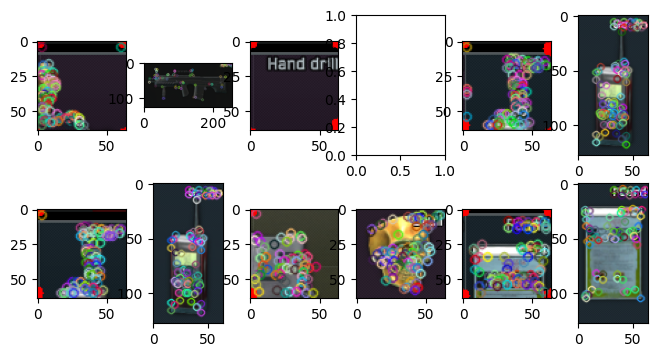

In [39]:
predictions_here = predictions

fig = plt.figure(figsize=(8, 4))
columns = 6
rows = 2
for i in range(0,columns*rows,2):
    img = item_images[(int) (i/2)].copy()
    fig.add_subplot(rows, columns, i+1)
    kp,des = run_sift(img)
    # print(f"size kp: {len(kp)}")
    img = cv2.drawKeypoints(img,kp,img)
    plt.imshow(img)

    img = icons[predictions[(int) (i/2)]].copy()
    fig.add_subplot(rows, columns, i+2)

    # filter invalid predictions
    if predictions[(int) (i/2)] == 0:
        continue

    kp,des = run_sift(img)
    img = cv2.drawKeypoints(img,kp,img)
    plt.imshow(img)
plt.show()

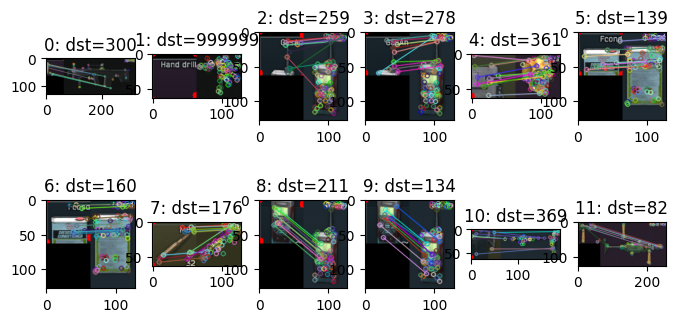

In [40]:
fig = plt.figure(figsize=(8, 4))
columns = 6
rows = 2
for i in range(0,columns*rows,1):
    img1 = item_images[i].copy()
    kp1,des1 = run_sift(img1, nr_corners=50, nr_selected_corners=10)
    
    img2 = icons[predictions[i]].copy()
    kp2,des2 = run_sift(img2)

    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
                
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)
    
    distance = (int) (distances[i])
        
    fig.add_subplot(rows, columns, i+1, title=f"{i}: dst={distance}")
    plt.imshow(img3)
    
plt.show()

In [ ]:
item_images = get_items_from_inventory(img_inventory, slot_locations)

In [171]:
img = scale_image(item_images[6]) # 22 is syringe
kp_img,des_img = run_sift(img, scale=1)
# img2 = draw_keypoints(img, kp=kp_img)
# Image.fromarray(img2)

img_inv = scale_image(img_inventory)
kp_inv,des_inv = run_sift(img_inv, scale=1) # 15secs
# inv_kp = draw_keypoints(img_inventory, kp=kp_inv)
# Image.fromarray(inv_kp)

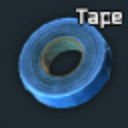

In [172]:
img2 = scale_image(icons[200])
kp_img2,des_img2 = run_sift(img2, scale=1)

Image.fromarray(draw_keypoints(img2, kp=kp_img2, scale=1))

In [ ]:
def matches_stats(matches, kp):
    x, y = 0, 0
    distance = 0
    for m in matches:
        index = m.queryIdx
        point = kp[index].pt
        x += point[0]
        y += point[1]
        distance += m.distance
    x /= len(matches)
    y /= len(matches)
    mean = ((int) (x),(int) (y))
    distance = (int) (distance)
    return mean,distance

img3 = img_inv.copy()

for i,d in enumerate(descriptors):
    if i%100 == 0:
        print(f"Checking item nr {i}")
    if d is None or len(d) == 0:
        continue
    
    matches = bf.match(des_inv, d)
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:10]

    mean,dist = matches_stats(matches, kp_inv)

    if dist < 600:
        print(f"Center of matches: {mean}", end='\t-- ')
        print(f"Dist: {dist}")
        img3 = cv2.circle(img3, mean, radius=10, color=(0,0,255), thickness=-1)

In [ ]:
# img3 = cv2.drawMatches(img_inv, kp_inv, img2, kp_img, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# img3 = cv2.circle(img3, mean, radius=10, color=(0,0,255), thickness=-1)
# print(f"Image shape: {img3.shape}")
Image.fromarray(img3)

## Fast corners

In [129]:
item_images = get_items_from_inventory(img_inventory, slot_locations)
fast = cv2.FastFeatureDetector_create(threshold=0)
global sift

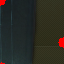

In [130]:
Image.fromarray(item_images[19])

In [158]:
img = scale_image(item_images[130], scale_factor=1) # 22,23,24 is syringe
kp_img,des_img = run_sift(img, nr_corners=20)
print(f"size kp_img: {len(kp_img)}")
img_kp = cv2.drawKeypoints(img, kp_img, None, color=(0,255,0))

print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp_img)) )


img2 = scale_image(icons[1712], scale_factor=1) # 1712 is syringe
kp_img2,kp_des2 = run_fast(img2)

# match
matches = bf.match(des_img,kp_des2)
matches = sorted(matches, key = lambda x:x.distance)

print(f"size matches: {len(matches)}")

# matches = matches[:60]

distance = 0
for m in matches:
    distance += m.distance
distance /= len(matches)

print(f"Total Distance: {distance}")
img3 = cv2.drawMatches(img, kp_img, img2, kp_img2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

size kp_img: 17
Total Keypoints with nonmaxSuppression: 17
threshold is 0 	-- nr kp: 100
threshold is 2 	-- nr kp: 94
threshold is 4 	-- nr kp: 89
threshold is 6 	-- nr kp: 76
size matches: 17
Total Distance: 475.35803043141084


17


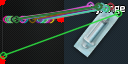

In [159]:
print(len(matches))
Image.fromarray(img3)

In [161]:
for kp in kp_img:
    print(kp.pt)

(6.0, 19.0)
(8.0, 19.0)
(10.0, 19.0)
(12.0, 19.0)
(14.0, 19.0)
(16.0, 19.0)
(22.0, 19.0)
(24.0, 19.0)
(32.0, 19.0)
(38.0, 19.0)
(40.0, 19.0)
(42.0, 19.0)
(44.0, 19.0)
(46.0, 19.0)
(48.0, 19.0)
(50.0, 19.0)
(3.0, 55.0)


In [65]:
df = all_items_df
a = df['name'].str.find("Sy")
for i,j in enumerate(a):
    if j != -1:
        print(i, df.loc[i,'name'])

1712 Syringe


In [ ]:
img = cv.imread('blox.jpg',0) # `<opencv_root>/samples/data/blox.jpg`
# Initiate FAST object with default values
fast = cv.FastFeatureDetector_create()
# find and draw the keypoints
kp = fast.detect(img,None)
img2 = cv.drawKeypoints(img, kp, None, color=(255,0,0))
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
cv.imwrite('fast_true.png', img2)
# Disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img, None)
print( "Total Keypoints without nonmaxSuppression: {}".format(len(kp)) )
img3 = cv.drawKeypoints(img, kp, None, color=(255,0,0))
cv.imwrite('fast_false.png', img3)

In [ ]:
def run_sift(img):
    global sift
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     edge = cv2.Canny(gray, threshold1=50, threshold2=50)
#     gray = cv2.blur(gray, (3,3))
    kp,des = sift.detectAndCompute(gray,None)
    return kp,des

In [ ]:
i = 200
img1 = icons[i].copy()
img1 = cv2.resize(img1, ((int) (img1.shape[0]*window_scale_factor), (int) (img1.shape[1]*window_scale_factor)))
kp1,des1 = run_sift(img1)
img1 = cv2.drawKeypoints(img1,kp1,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

Image.fromarray(img1)

In [ ]:
i = 2
img2 = item_images[i].copy()
kp2,des2 = run_sift(img2)
img2 = cv2.drawKeypoints(img2,kp2,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

Image.fromarray(img2)

In [ ]:
matches = bf.match(des1,des2)
# Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:20]
                
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
Image.fromarray(img3)

In [ ]:
distance = 0.0
for match in matches:
    distance += match.distance/len(matches)
    
print(distance)

In [ ]:
predictions

In [ ]:
Image.fromarray(inventory_filtered)

In [ ]:
# Image.fromarray(img_slot_np_edge)
# Image.fromarray(res)
# plt.imshow(res[3], cmap='gray')
Image.fromarray(img_inventory)
# Image.fromarray(hough)

In [ ]:
downscale = 2
img = img_inventory.copy()
img = cv2.resize(img, ((int) (img.shape[1]/downscale)
                                 , (int) (img.shape[0]/downscale)))

img_inventory_edge = edge_detection(img)

img_horizontal = img_inventory_edge.copy()
img_vertical = img_inventory_edge.copy()

line_length = (int) (40/downscale)
horizontal_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (line_length,1))
vertical_struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,line_length))

cv2.erode(img_horizontal, horizontal_struct, img_horizontal)
cv2.dilate(img_horizontal, horizontal_struct, img_horizontal)

cv2.erode(img_vertical, vertical_struct, img_vertical)
cv2.dilate(img_vertical, vertical_struct, img_vertical)

result = cv2.add(img_horizontal, img_vertical)

In [ ]:
img.shape

In [ ]:
Image.fromarray(result)

## Flea tax calculation

In [37]:
all_items_df = pd.read_csv(path_data + 'all_items.csv')

In [49]:
base_multipliers = {'therapist': 0.63, 'ragman': 0.62, 'jaeger': 0.6, 'mechanic':0.56
        , 'prapor': 0.5, 'skier': 0.49, 'peacekeeper': 0.45, 'fence': 0.4}

t_i = 0.05
t_r = 0.1

In [52]:
def tax(itemindex, price_rubels):
    global all_items_df

    if price_rubels == 0:
        return 0

    baseprice = all_items_df.loc[itemindex, 'basePrice']
    quantity = 1
    quantity_factor = 1
    v_o = baseprice * quantity / quantity_factor
    if v_o == 0:
        return 0
    v_r = price_rubels # value of requirements
    p_o = np.log10(v_o / v_r)
    p_r = np.log10(v_r / v_o)

    tax = v_o * t_i * (4**p_o) * quantity_factor + v_r * t_r * (4**p_r) * quantity_factor
    return tax

itemindex = 1000
price = 10000 # in rubels

tax = tax(1000, 10000)

print(f"tax is: {tax} \t-- Profit: {price - tax}")

tax is: 1491.232081347421 	-- Profit: 8508.767918652578


In [47]:
print(all_items_df[all_items_df['name'].str.contains("USD")])

    name                        id  width  height  icon_width  icon_height  \
128  USD  5696686a4bdc2da3298b456a      1       1         NaN          NaN   

     features  fleaMarket  flea_avg48  flea_ch48percent  prapor  therapist  \
128       NaN         NaN           0               NaN     NaN        NaN   

     fence  skier  peacekeeper  mechanic  ragman  jaeger  basePrice  
128    NaN    NaN          NaN       NaN     NaN     NaN        100  


In [38]:
all_items_df


,name,id,width,height,icon_width,icon_height,features,fleaMarket,flea_avg48,flea_ch48percent,prapor,therapist,fence,skier,peacekeeper,mechanic,ragman,jaeger,basePrice
0,M4A1,5447a9cd4bdc2dbd208b4567,1,1,NaN,NaN,NaN,49995.0,76102,-51.03,9198.0,NaN,7358.0,NaN,83.0,10302.0,NaN,NaN,18397
1,M855,5447ac644bdc2d6c208b4567,1,1,NaN,NaN,NaN,2000.0,0,0.00,NaN,NaN,400.0,NaN,NaN,NaN,NaN,NaN,1000
2,Factory,5448ba0b4bdc2d02308b456c,1,1,NaN,NaN,NaN,88000.0,87753,8.61,25000.0,31500.0,NaN,NaN,NaN,NaN,NaN,NaN,50000
3,PM,5448bd6b4bdc2dfc2f8b4569,2,1,NaN,NaN,NaN,5000.0,7122,-15.80,2548.0,NaN,2038.0,NaN,23.0,2854.0,NaN,NaN,5097
4,RGD-5,5448be9a4bdc2dfd2f8b456a,1,1,NaN,NaN,NaN,10420.0,13492,-4.76,3615.0,NaN,2892.0,3542.0,NaN,NaN,NaN,NaN,7230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,Batwolf,62a61c988ec41a51b34758d5,2,1,NaN,NaN,NaN,23000.0,26425,0.50,NaN,NaN,7200.0,8820.0,81.0,NaN,11160.0,NaN,18000
2719,Barrack,62a9cb937377a65d7b070cef,1,1,NaN,NaN,NaN,33330.0,34076,-23.68,20000.0,25200.0,NaN,NaN,NaN,NaN,NaN,NaN,40000
2720,Dogtag,customdogtags12345678910,1,1,NaN,NaN,NaN,NaN,0,NaN,300.0,378.0,240.0,294.0,NaN,NaN,NaN,NaN,600
2721,Glock 17 PS9,glock17ps900000000000001,2,1,NaN,NaN,NaN,NaN,0,0.00,29554.0,NaN,23643.0,NaN,266.0,33100.0,NaN,NaN,59108
